# Aufgabe5 – Interpretation von Modellen

## Notebook Beschreibung
In diesem Notebook wird ein Datensatz analysiert, welcher Kreditanträge enthält. Jede Zeile enthält dabei Merkmale über den Kunden und ob der Kreditantrag abgelehnt wurde. Es werden verschiedene Klassifikatoren trainiert, um die verschiedenen Einflussfaktoren auf die Ablehnungsentscheidung zu ermitteln. Ergebnis ist, dass vor allem Anträge von Kunden abgelehnt werden, die keine Versicherung für den Kredit erhalten haben, bereits Kredite nicht zurückzahlen konnten und ein verhältnismäßig geringes Einkommen besitzen. Es konnte außerdem gezeigt werden, dass Anträge von Kunden mit schwarzer Hauptfarbe von den Klassifikatoren eher als abgelehnt klassifiziert werden. Dies kann ein Hinweis auf eine rassistische Diskriminierung sein, beweist aber keinen kausalen Zusammenhang.

## Vorgehen
1. Modul-Importe und Einstellungen
- Analyse und Datenvorverarbeitung
- Feature Importance mit logistischer Regression
- Vergleich weiterer Modelle

## Modul-Importe und Einstellungen

In [1]:
# Modul Pfad setzen
import sys
sys.path.append('./module')


# Bibliotheken importieren
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC, SVC

import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display, Markdown

## Analyse und Datenvorverarbeitung

Aufgabe 5a)  
Lesen Sie den Datensatz Hdma.csv ein und machen Sie sich mit den Daten vertraut.  
Aufgabe 5c)  
Ist Datenvorverarbeitung nötig? Warum? Falls nötig, verarbeiten Sie die Daten vor.

Im folgenden Abschnitt werden diese beiden Aufgaben zuerst gelöst. Die Daten werden analysiert und direkt bei Bedarf vorverarbeitet. Dies ist zum Beispiel nötig, wenn es null Werte in den Daten gibt, extreme Ausreißer vorliegen oder kategorische Daten umgewandelt werden müssen.

In [2]:
# Load Dataset from csv (use ; as separator)
data = pd.read_csv('./data/Hdma.csv', sep=';')
# Display first line to test if data was loaded correctly
data.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [3]:
# Show dataframe size
data.shape

(2381, 13)

Der Datensatz besteht aus 2381 Datenpunkten mit jeweils 13 Merkmalen

In [4]:
data.isnull().any()

dir       False
hir       False
lvr       False
ccs       False
mcs       False
pbcr       True
dmi       False
self       True
single    False
uria      False
condo     False
black     False
deny      False
dtype: bool

Die Spalten "pbcr" und "self" enthalten fehlende Daten.

In [5]:
data[data.isnull().any(axis=1)]

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
2380,0.330814,0.255346,0.700783,2.116387,1.721008,NaN,no,NaN,yes,3.774496,0,no,no


Nur in einer Zeile ist "pbcr" und "self" gleich NaN. Da es nur eine einzige Zeile mit fehlenden Daten gibt, haben wir uns entschieden diese aus dem Datensatz zu entfernen.

In [6]:
data = data.drop(2380)
data.shape

(2380, 13)

### Art der Merkmale 

In [7]:
data.columns

Index(['dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single',
       'uria', 'condo', 'black', 'deny'],
      dtype='object')

- `dir` numerisch-kontinuierlich 
- `hir` numerisch-kontinuierlich
- `lvr` numerisch-kontinuierlich
- `ccs` kategorisch-ordinal
- `mcs` kategorisch-ordinal
- `pbcr` kategorisch-nominal
- `dmi` kategorisch-nominal
- `self` kategorisch-nominal
- `single` kategorisch-nominal
- `uria` numerisch-kontinuierlich
- `condo` kategorisch-nominal
- `black` kategorisch-nominal
- `deny` kategorisch-nominal


Die Zielvariable der Klassifikation ist 'deny' welche angibt, ob der Kreditantrag abgelehnt wurde. Zunächst wird die Verteilung dieser Variable genauer betrachtet.

### Verteilung der Variablen

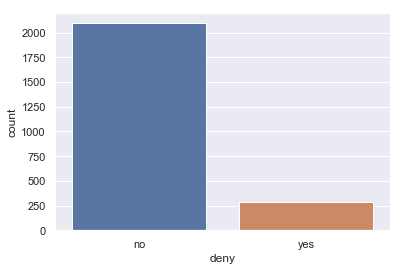

Not denied: 88.0%
Denied: 12.0%


In [8]:
# create a countplot that shows the distribution of deny
sns.countplot(x='deny',data=data)
plt.show()
# Compute and print the percentage of denied and not denied examples
percentages = data['deny'].value_counts() / data.shape[0]
print("Not denied: {:.1f}%".format(percentages[0] * 100))
print("Denied: {:.1f}%".format(percentages[1] * 100))

Es ist zu sehen, dass es eine große Imbalance im Datensatz gibt. 88% der Kreditanträge wurden genehmigt. Entsprechend sind nur 12% der Daten eine Ablehnung. Dies muss bei der späteren Evaluation beachtet werden.

Es gibt einige binäre nominale Merkmale die entweder den Wert 'yes' oder 'no' besitzen. Diese werden in die Werte 0 und 1 umgewandelt.

In [9]:
# yes-no features
nominal_features = ['pbcr', 'dmi', 'self', 'single', 'condo', 'black', 'deny']
labelencoder = LabelEncoder()
# Apply the Labelencoder to each column with yes-no features
data[nominal_features] = data[nominal_features].apply(labelencoder.fit_transform)
data.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,0,0,0,0,3.9,0,0,0
1,0.265,0.265,0.921875,2.0,2.0,0,0,0,1,3.2,0,0,0
2,0.372,0.248,0.920398,1.0,2.0,0,0,0,0,3.2,0,0,0
3,0.320,0.250,0.860465,1.0,2.0,0,0,0,0,4.3,0,0,0
4,0.360,0.350,0.600000,1.0,1.0,0,0,0,0,3.2,0,0,0


Der Datensatz enthält drei kontinuierliche Merkmale. Deren Verteilung wird im Folgenden untersucht.

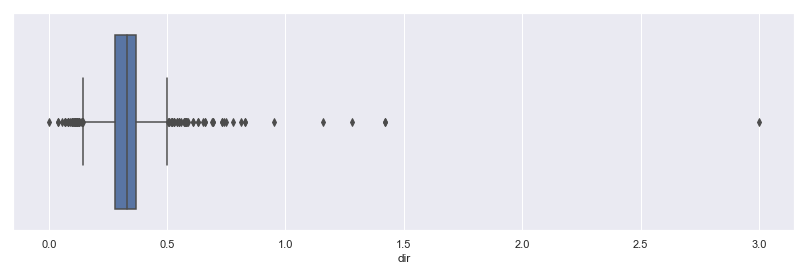

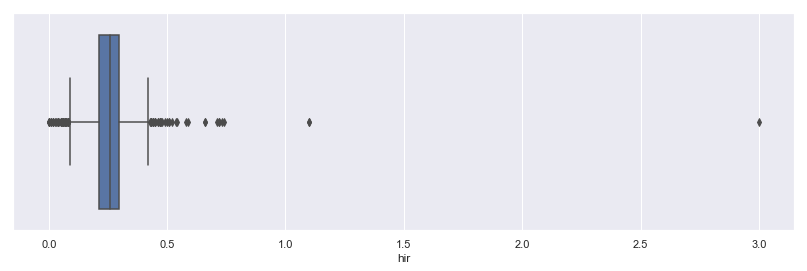

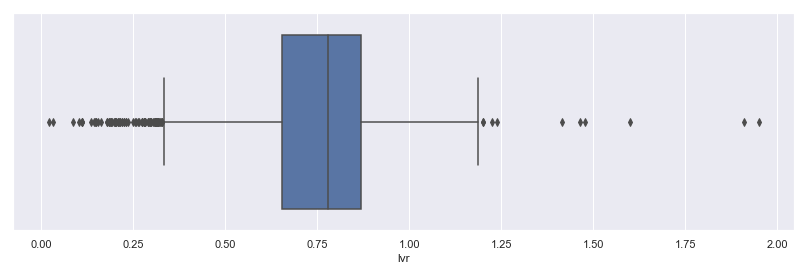

In [10]:
# define continuous features
continuous_features = ['dir', 'hir', 'lvr']
# create boxplot for each feature
for feature in continuous_features:
    plt.figure(figsize=(14, 4))
    sns.boxplot(data[feature])
    plt.show()

Im Boxplot der Merkmale "dir" und "hir" fällt auf, dass es einen sehr extremen Ausreißer mit einem Wert von 3.0 gibt. Dieser Wert ist sehr weit entfernt von allen anderen Datenpunkten und wird deshalb genauer betrachtet.

In [11]:
# Find outlier with "dir" grater than 2
outliers = data[data["dir"]>2]
outliers.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
1094,3.0,3.0,0.571429,1.0,3.0,0,0,1,0,10.6,0,0,1


Es stellt sich heraus, dass in einem Datenpunkt sowohl "dir" als auch "hir" einen extrem hohen Wert haben. Da über 2000 Trainingsbeispiele zur Verfügung stehen, haben wir uns dazu entschieden diese Zeile aus dem Datensatz zu entfernen, damit das Training nicht beeinflusst wird.

In [12]:
data.drop(outliers.index, inplace=True)
data.shape

(2379, 13)

Als letzter Punkt der Datenanalyse wird noch die Korrelation zwischen allen Merkmalen und der Zielvariable bestimmt

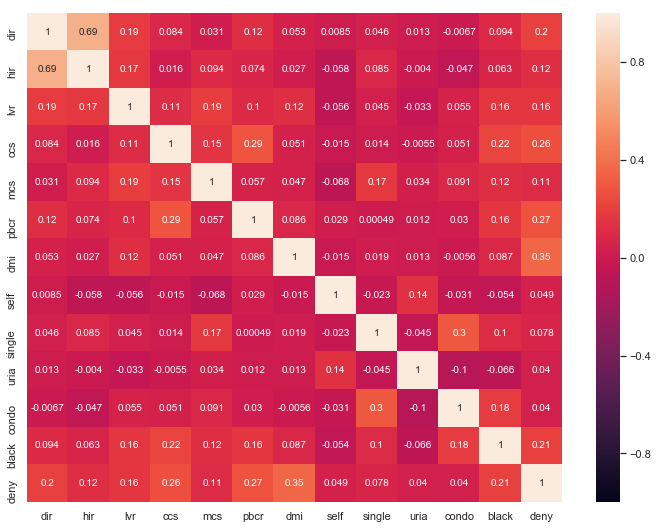

In [13]:
# compute correlation matrix
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True)
plt.show()

Es ist zu erkennen, dass keins der Merkmale besonders stark mit der Zielvariable korreliert. Die stärkste Korrelation besteht zwischen "dmi" und "deny" (0.35). Es gibt allerdings eine hohe Korrelation von 0.69 zwischen den beiden Merkmalen "hir" und "dir". Dies muss im Folgenden bei der Betrachtung der Feature Importance beachtet werden.

## Feature Importance mit logistischer Regression

Aufgabe 5b)  
Volkswirtschaftler möchten herausfinden, was die möglichen Einflussfaktoren auf die
Ablehnung eines Kreditantrags sind, und ob es eine rassistische Diskriminierung gibt.
Welcher Typ von Aufgabe des maschinellen Lernens ist für diese Aufgabe geeignet? Welche
Methoden kann man benutzen?

Es handelt sich hierbei um eine binäre Klassifikation, da die Zielvariable "deny" vorhergesagt werden soll. Im Besonderen soll festgestellt werden, welche Faktoren eine Ablehnung besonders beeinflussen. Daher müssen Klassifikationsmethoden gewählt werden, die das Bestimmen der Feature Importance erlauben.  
Es soll im Besonderen bestimmt werden, ob es bei der Entscheidung eine rassistische Diskriminierung gibt. Hierfür muss der Einfluss des Merkmals "black" untersucht werden.

Aufgabe 5d)  
Separieren Sie die Daten in 80% : 20% = Training : Test Datensatz. Führen Sie eine logistische
Regression durch. Beschreiben Sie Koeffizienten und deren Signifikanzniveau sowie die Area
Under Curve (AUC) der Receiver-Operator-Curve (ROC). Interpretieren Sie die Ergebnisse.

In [14]:
# Create numpy arrays for features and target
X = data.drop(["deny"], axis=1)
y = data["deny"]
# Create 80/20 train val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
# Print resulting dataset sizes
print("Shape X_train", X_train.shape)
print("Shape y_train", y_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_test", y_test.shape)

Shape X_train (1903, 12)
Shape y_train (1903,)
Shape X_test (476, 12)
Shape y_test (476,)


Wir haben uns dazu entschieden die Daten nicht zu normalisieren (z.B. durch einen StandardScaler). Hierdurch können die gelernten Koeffizienten besser interpretiert werden. Es muss daher aber auch beachtet werden, dass ein höherer Koeffizient nicht zwingend eine höhere Wichtigkeit des Merkmals bedeutet.

Im Folgenden verwenden wir die statsmodels Pythonbibliothek, um die logistische Regression zu trainieren. Diese bietet gegenüber scikit-learn weitere statistische Kennwerte, wie zum Beispiel den P-Wert jedes Koeffizienten, der die Signifikanz beschreibt.

In [15]:
# creat logistic regression model and use add_constant to add an intercept
logistic_regression = smf.Logit(y_train, sm.add_constant(X_train))
# fit the model
lr_model = logistic_regression.fit()

def evaluate_model(model, X, y, threshold):
    y_prediction_proba = model.predict(sm.add_constant(X)) 
    y_prediction_class = y_prediction_proba >= threshold
    print_scores(y, y_prediction_class)
    
def print_scores(y_true, y_pred):
    # Print the accuracy and balanced accuracy score
    print("Accuracy score: {:.3f}".format(
        metrics.accuracy_score(y_true, y_pred)
    ))
    print("Balanced accuracy score:{:.3f}".format(
        metrics.balanced_accuracy_score(y_true, y_pred)
    ))
    
# Use model to make predictions on the train and test set. Use a threshold of 0.5
print("Scores on train:")
evaluate_model(lr_model, X_train, y_train, 0.5)
print("-"*20)
print("Scores on test:")
evaluate_model(lr_model, X_test, y_test, 0.5)

Optimization terminated successfully.
         Current function value: 0.270975
         Iterations 7
Scores on train:
Accuracy score: 0.902
Balanced accuracy score:0.645
--------------------
Scores on test:
Accuracy score: 0.918
Balanced accuracy score:0.642


/Users/d062356/miniconda3/envs/smart-data-analytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Die Evaluation auf dem Trainings- und Testdatensatz ergeben einen sehr ähnlichen Score. Dies lässt darauf schließen, dass das Modell gut auf ungesehene Daten generalisiert und nicht overfittet. Die Accuracy von über 90% scheint zunächst sehr gut. Aufgrund der ungleichen Verteilung der Zielvariable erreicht allerdings auch ein Modell, das für alle Daten die Klasse 0 vorhersagt, bereits eine Accuracy von 88%. Daher wurde zusätzlich der balanced accuracy score verwendet, der aus dem durchschnittlichen Recall jeder Klasse berechnet wird. Als Schwellwert für die Zuordnung zu 0 oder 1 wurde 0.5 ausgewählt. Diese Auswahl war allerdings beliebig und vor allem auf Hinblick der Imbalance im Datensatz ist zu erwarten, dass ein anderer Schwellwert besser geeignet ist. Um einen besseren Schwellwert zu finden, wird im Folgenden eine Receiver-Operator-Curve (ROC) auf den Trainingsdaten erstellt.

### Evaluation der ROC-Kurve

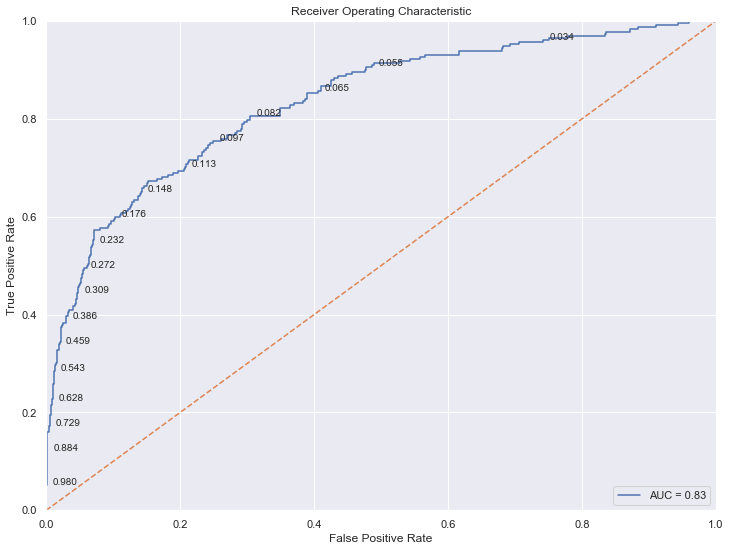

In [16]:
def create_roc_auc_plot(y_prob, y):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(12,9))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = "AUC = {:.2f}".format(roc_auc))
    prev_threshold = tpr[0]
    for i, threshold in enumerate(thresholds):
        if tpr[i] - prev_threshold  > 0.05:
            prev_threshold = tpr[i]
            plt.annotate("{:.3f}".format(threshold), (fpr[i]+0.01, tpr[i]))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
create_roc_auc_plot(lr_model.predict(sm.add_constant(X_train)), y_train)

Im Plot der ROC ist zu erkennen, dass der zuvor gewählte Schwellwert von 0,5 nicht sehr gut ist. Wählt man beispielsweise einen Schwellwert von 0,23, so kann die "True Positive Rate" deutlich gesteigert werden, ohne zu große Abstriche bei der "False Positive Rate" zu machen. Danach wächst die TPR nur noch weniger stark an. In einem realen Anwendungsfall muss zwischen TPR und FPR abgewägt werden und entsprechend der Schwellwert gesetzt werden.

In [17]:
# Use model to make predictions on the train and test set. Use new threshold of 0.23
print("Scores on train:")
evaluate_model(lr_model, X_train, y_train, 0.23)
print("-"*20)
print("Scores on test:")
evaluate_model(lr_model, X_test, y_test, 0.23)

Scores on train:
Accuracy score: 0.884
Balanced accuracy score:0.739
--------------------
Scores on test:
Accuracy score: 0.912
Balanced accuracy score:0.740


Mit dem neuen Threshold ist die Accuracy auf den Testdaten fast gleich geblieben, der Balanced Accuracy Score konnte allerdings deutlich erhöht werden. Dies liegt daran, dass nun mehr abgelehnte Anträge auch als solche klassifiziert wurden.  
Nachdem ein guter Threshold gefunden wurde wird nun die ROC-Kurve auch noch für die Testdaten bestimmt

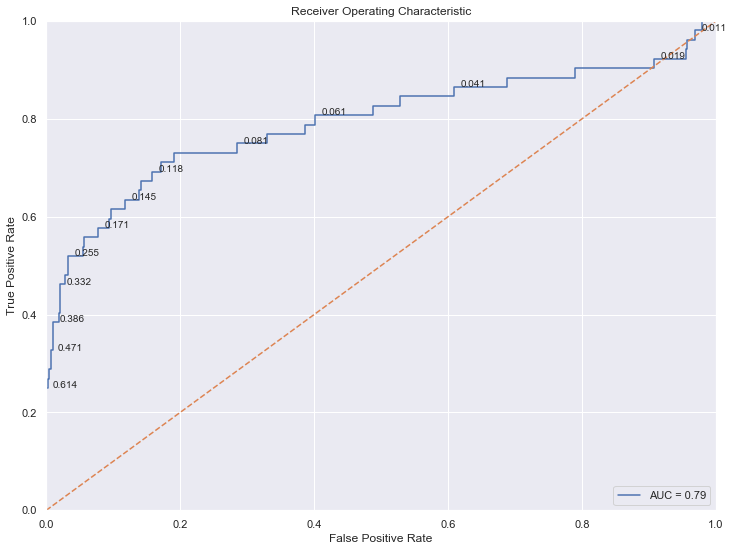

In [18]:
create_roc_auc_plot(lr_model.predict(sm.add_constant(X_test)), y_test)

Die ROC-Kurve sieht ähnlich aus wie die der Trainingsdaten. Daher ist auch die Area
Under Curve (AUC) ähnlich hoch. Diese berechnet sich aus der Fläche unter der blauen Kurve und gibt an, wie gut das Modell die Klassen separieren kann. Ein Modell, welches zufällig die Klasse vorhersagt, hat eine AUC von 0,5. Ein optimales Modell erreichte eine AUC von 1,0. Eine AUC von 0.79 auf den Testdaten ist also schon ein gutes Ergebnis. Es lässt sich so interpretieren, dass bei Wahl des besten Schwellwertes mit einer Wahrscheinlichkeit von 79% zwischen der positiven und negativen Klasse unterschieden werden kann.  
Generell muss man allerdings vorsichtig sein, wenn man die ROC-Kurve und die AUC zur Bewertung eines Modells verwendet, welches auf ungleich verteilten Daten trainiert wurde. In diesem Fall gibt es sehr viel mehr negative Beispiele als positive. Daher ändert sich False Positive Rate nur sehr langsam, wohingegen die True Positive Rate sensibler ist.

### Betrachtung der Koeffizienten

Durch die Betrachtung der ROC-Kurve konnte ein guter Schwellwert gefunden werden und die AUC bestätigt dies. Als Nächstes werden daher die Koeffizienten des gelernten Modells betrachtet, die Aufschluss über die Feature Importance geben.

In [19]:
# get coefficients and their significance from the result
coef_table = lr_model.summary2().tables[1].round(4)
coef_table

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-7.4088,0.6219,-11.9126,0.0000,-8.6278,-6.1898
dir,4.3168,1.1526,3.7451,0.0002,2.0576,6.5759
hir,0.4814,1.4209,0.3388,0.7347,-2.3035,3.2664
lvr,2.0774,0.5553,3.7412,0.0002,0.9891,3.1657
ccs,0.2920,0.0440,6.6340,0.0000,0.2057,0.3783
mcs,0.2218,0.1558,1.4241,0.1544,-0.0835,0.5271
pbcr,1.2138,0.2249,5.3958,0.0000,0.7729,1.6546
dmi,4.2991,0.5673,7.5781,0.0000,3.1872,5.4110
self,0.5647,0.2362,2.3914,0.0168,0.1019,1.0276
single,0.3552,0.1736,2.0467,0.0407,0.0151,0.6954


Die Tabelle zeigt zu jedem Merkmal den gelernten Koeffizienten. Das Merkmal "const" steht hierbei für den Achsenabschnitt (intercept). Der Betrag des Koeffizienten kann nicht direkt als die Wichtigkeit des Merkmals interpretiert werden, da die Merkmale unterschiedlich skaliert sind. Die binären Merkmale (ja/nein) lassen sich allerdings direkt vergleichen, da hier dieselbe Skala vorliegt. Zu jedem Koeffizienten ist außerdem die Standardabweichung angegeben. Diese sagt aus wie stark der Koeffizient bei mehrmaligem Trainieren auf einem Teil der Daten variiert. Hieraus lässt sich ein p-Wert bestimmen, welcher in der Spalte "P>|z|" steht. Dieser gibt die Wahrscheinlichkeit an, mit der die Null-Hypothese für diesen Koeffizienten gilt. Das bedeutet, mit welcher Wahrscheinlichkeit das Merkmal nicht relevant für die Vorhersage der Zielvariable ist. Oft wird festgelegt, dass Merkmale mit einem p-Wert von nicht mehr als 0.05 als statistisch signifikant gelten. Zusätzlich zum P-Wert wird außerdem das Konfidenzintervall mit einem Konfidenzniveau von 95% angegeben. Mit einer Wahrscheinlichkeit von 95% umschließt dieses Intervall den wahren Koeffizienten.

Eine wichtige Bemerkung ist, dass in der Koeffizienten-Tabelle das Merkmal "dir" eine sehr hohe Signifikanz hat, das Merkmal "hir" allerdings alls irrelevant eingestuft wird. In der Korrelationsanalyse wurde allerdings festgestellt, dass "dir" und "hir stark miteinander korrelieren. Würde die Regression also ohne das Merkmal "dir" durchgeführt werden, so erhält "hir" einen Koeffizienten, der statistisch signifikant ist. Es wäre also ein falsche Schluss zu behaupten, dass das "hir" Merkmal für die Vergabe eines Kredites nicht relevant sei.

In [20]:
coef_table[coef_table["P>|z|"] <= 0.05]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-7.4088,0.6219,-11.9126,0.0000,-8.6278,-6.1898
dir,4.3168,1.1526,3.7451,0.0002,2.0576,6.5759
lvr,2.0774,0.5553,3.7412,0.0002,0.9891,3.1657
ccs,0.2920,0.0440,6.6340,0.0000,0.2057,0.3783
pbcr,1.2138,0.2249,5.3958,0.0000,0.7729,1.6546
dmi,4.2991,0.5673,7.5781,0.0000,3.1872,5.4110
self,0.5647,0.2362,2.3914,0.0168,0.1019,1.0276
single,0.3552,0.1736,2.0467,0.0407,0.0151,0.6954
uria,0.0875,0.0358,2.4471,0.0144,0.0174,0.1576
black,0.6939,0.2004,3.4616,0.0005,0.3010,1.0867


In der obigen Tabelle sind aller Merkmale aufgelistet, deren Einfluss auf die Zielvariable statistisch signifikant sind. Von den Ja/Nein Merkmalen hat "dmi" den größten Einfluss auf die Vergabe eines Kredits. "dmi" steht für "denied mortgage insurance" und sagt aus, ob dem Kunden bereits eine Hypothekenversicherung abgelehnt wurde. Es war zu erwarten, dass dieses Merkmal einen großen Einfluss auf die Vergabe eines neuen Kredits hat. Das Versicherungsunternehmen schätzt bereits das Risiko anhand von vielen Merkmalen ab. Wird eine Versicherung daraufhin verwehrt, so ist es wahrscheinlich auch für die Bank zu risikoreich einen Kredit zu vergeben.  
Das zweitwichtigste Ja/Nein Merkmal ist "pbcr"(public bad credit record) und beschreibt, ob der Kunde in der Vergangenheit Kredite nicht fristgemäß zurückgezahlt hat. Auch bei diesem Attribut macht es intuitiv Sinn, dass Kunden mit denen bereits schlechte Erfahrungen gemacht wurden auch häufiger abgelehnt werden.   
Das drittwichtigste Ja/Nein Merkmal ist "black". Kreditanträge von Personen mit dunkler Hautfarbe werden also öfter abgelehnt. Dies gibt einen Hinweis darauf, dass es möglicherweise eine rassistische Diskriminierung gibt. Allerdings ist durch die Feature Importance kein kausaler Zusammenhang gegeben. Es ist zum Beispiel möglich, dass Personen mit dunkler Hautfarbe generell ein geringeres Einkommen besitzen und daher seltener einen Kredit bekommen.

### Untersuchung der class_weight Eigenschaft

Aufgabe 5e)  
Manche Methoden in scikit-learn haben den Parameter class_weight. Wann sollte man
class_weight = 'balanced' setzen? Ist es in dieser Aufgabe nötig?

Um diese Frage zu klären, wird zunächst die LogistischeRegression Klasse aus sklearn mit und ohne dem Parameter class_weight = 'balanced' trainiert und die Ergebnisse verglichen.

#### Logistic regression without class_weight

Scores on train:
Accuracy score: 0.901
Balanced accuracy score:0.635
Scores on test:
Accuracy score: 0.918
Balanced accuracy score:0.633


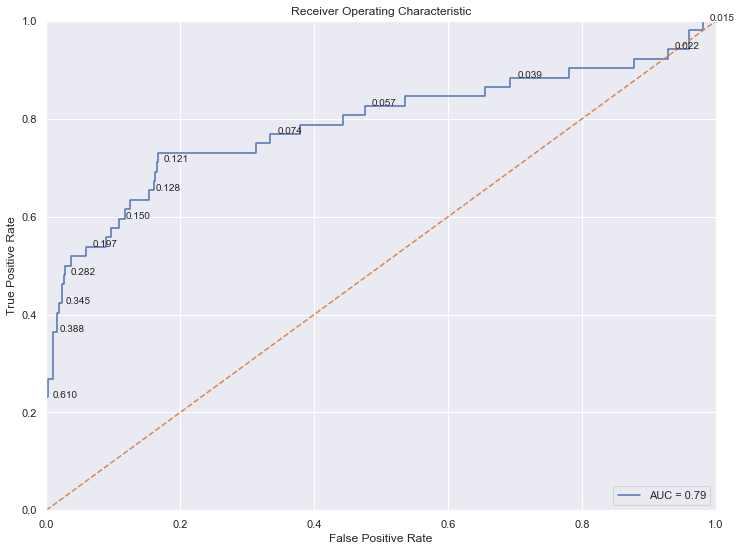

#### Logistic regression with class_weight="balanced"

Scores on train:
Accuracy score: 0.791
Balanced accuracy score:0.742
Scores on test:
Accuracy score: 0.830
Balanced accuracy score:0.770


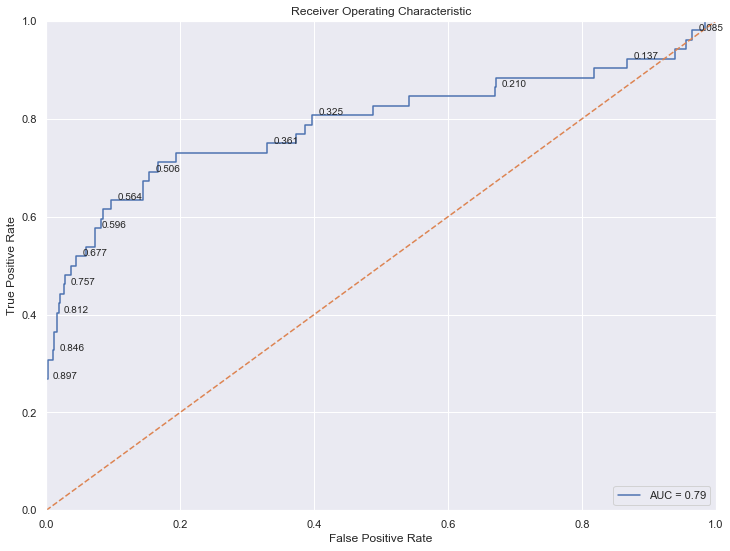

In [21]:
def test_sklearn_logistic_regression(class_weight = None):
    sklearn_lr = LogisticRegression(solver="lbfgs", class_weight = class_weight)
    sklearn_lr.fit(X_train, y_train)
    print("Scores on train:")
    print_scores(y_train, sklearn_lr.predict(X_train))
    print("Scores on test:")
    print_scores(y_test, sklearn_lr.predict(X_test))
    create_roc_auc_plot(sklearn_lr.predict_proba(X_test)[:,1], y_test)
display(Markdown('#### Logistic regression without class_weight'))
test_sklearn_logistic_regression()
display(Markdown('#### Logistic regression with class_weight="balanced"'))

test_sklearn_logistic_regression("balanced")

Die predict Methode der LogisticRegression aus sklearn verwendet intern einen Schwellwert von 0,5. Aus diesem Grund ist die Accuracy und Balanced Accuracy fast gleich mit dem gelernten statsmodels Modell, wenn dort auch ein Schwellwert von 0,5 gesetzt wird (siehe vorherige Aufgabe). Dementsprechend sieht auch die ROC-Kurve sehr ähnlich aus und es wird eine AUC von 0,79 erreicht.
Wird class_weight="balanced" gesetzt ist festzustellen, dass sich die Form der ROC-Kurve nicht ändert und auch die AUC gleich bleibt. Lediglich der Schwellwert, bei dem ein guter Kompromiss zwischen FPR und TPR getroffen wird, liegt nun näher an 0,5. Hierdurch liefert die predict Methode nun auch einen besseren Balanced Accuracy Score. Der Parameter class_weight="balanced" kann also bei ungleich verteilten Daten gesetzt werden, um ein besseres Ergebnis zu erziehlen ohne den Schwellwert manuell festzulegen. 

Aus der scikit-learn Dokumentation kann entnommen werden, dass durch das Setzen des Parameters jedes Trainingsbeispiel mit der folgenden Formel gewichtet wird:  
```n_samples / (n_classes * np.bincount(y))```  
Je mehr Trainingsbeispiele einer Klasse es gibt, desto niedriger wird dieses einzelne Beispiel gewichtet. Hierdurch wird die Entscheidungsgrenze ca. bei einem Schwellwert von 0,5 platziert, wie es bei einem balanciertem Datensatz der Fall wäre.  


Zusammenfassend kann gesagt werden, dass class_weight="balanced" gesetzt werden sollte, wenn sich die Anzahl an positiven und negativen Trainingsbeispiele stark unterscheidet. Dies ist bei diesem Trainingsdatensatz der Fall. Das manuelle Setzen des Schwellwerts (z.B. aufgrund der ROC-Kurve) bietet aber eine genauere Kontrolle über die TPR und FPR Rate. Je nach Anwendungsgebiet müssen hier andere Kompromisse eingegangen werden.

## Vergleich weiterer Modelle

Instanziieren der genannten Klassifikatoren

In [22]:
classifier_lregression = LogisticRegression(solver="lbfgs", class_weight = "balanced")
classifier_dtree = DecisionTreeClassifier(criterion = 'entropy', class_weight="balanced")
classifier_rforest = RandomForestClassifier(n_estimators = 200, random_state=0, class_weight="balanced")
classifier_adaboost = AdaBoostClassifier()
classifier_nb = ComplementNB() #particularly suited for imbalanced data sets
classifier_svm = SVC(kernel='linear', class_weight="balanced", probability=True, gamma="scale")

classifiers = [classifier_lregression, classifier_dtree, classifier_rforest, classifier_adaboost, classifier_nb, classifier_svm]


###### Trainieren der Klassifikatoren

In [23]:
for classifier in classifiers:
    classifier.fit(X_train, y_train)

###### Vergleich der Feature Importances

Alle verwendetetn Modelle bieten eine Möglichkeit aufzulisten welche Merkmale als besonders wichtig erachtet werden. 

- **Logistische Regression und Lineare SVM**   
Die Klassen `LogisticRegression` und `LinearSVC` bieten ein Attribut `coef_` an, welches für jedes Merkmal den gelernten Koeffizienten enthält. Bei der logistische Regression kann zum Beispiel der P-Wert berechnet werden, um die statistische Signifikanz des Einflusses eines Merkmales auf die Zielvariable zu zeigen. Da die Merkmale unterschiedlich skaliert sind, kann aus einem Koeffizienten mit hohem Betrag allerdings nicht automatisch geschlossen werden, dass dieses Merkmal wichtiger ist als eines mit niedrigerem Koeffizienten. Sind die Variablen gleich skaliert (wie zum Beispiel Ja/Nein Variablen), so können die Koeffizienten dieser Merkmale direkt verglichen werden.

- **Entscheidungsbaum, Random Forest und AdaBoost**  
Alle diese Methoden beruhen auf Entscheidungsbäumen welche in scikit-learn das Attribut `feature_importances_` besitzten. Dieser Wert basiert darauf, wie sehr ein Attribut dazu beiträgt, den sog. "Information Gain" in einem Knoten eines Entscheidungsbaums zu erhöhen bzw. die Entropie der Daten in dessen Kind-Knoten zu verringern. Scikit-learn verwendet die sogenannte "gini importance" um dieses Attribut zu berechnen. Hierdurch wird gemessen sehr ein Merkmal die Unsicherheit des Klassifikators reduziert.  
Die Wichtigkeit der einzelnen Merkmale kann hierdurch direkt untereinander verglichen werden. Allerdings muss beachtet werden, dass die gini importance zwar schnell berechnet werden kann, aber diese auch Ungenauigkeiten mit sich bringt. Die Wichtigkeit von kontinuierlichen Merkmalen wird zum Beispiel oft überschätzt (siehe https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25 ). 
Bei dem Random Forest Klassifikator wird der Durchschnitt der Feature Importance über alle Entscheidungsbäume für jedes Attribut berechnet.

- **Naive Bayes**  
Der Naive Bayes Klassifikator (`ComplementNB`) aus sklearn bietet mit dem Attribut `feature_log_prob_` Zugriff auf den Logarithmus der empirisch bestimmten Wahrscheinlichkeit eines Merkmals gegeben einer Klasse $P(X_i|y)$. Diese Wahrscheinlichkeit an sich bietet keine Möglichkeit, die Wichtigkeit eines Merkmals zu bestimmen. Soll zum Beispiel zwischen Hunden und Katzen unterschieden werden und es gäbe ein Merkmal "hat_beine" so wäre die Wahrscheinlichkeit P(hat_beine|Katze) und P(hat_beine|Hund) jeweils sehr hoch, aber das Merkmal ist nicht gut geeignet, um eine Klassifikation durchzuführen. Daher müssen die Wahrscheinlichkeiten für die positive und negative Klasse angeschaut werden. Bei unterschiedlicher Wahrscheinlichkeit ist das Merkmal gut für die Klassifikation geeignet.

Die Ergebnisse dieser verschiedenen Möglichkeiten die Feature Importance zu bestimmen lassen sich nicht direkt vergleichen. Oft ist selbst der direkte Vergleich der Wichtigkeit der verschiedenen Features in einem Klassifikator untereinander nicht möglich. Dies liegt an unterschiedlich skalierten Merkmalen und eventuellen Bias der Maße (z.B. Bevorzugung kontinuierlicher Merkmale).

In [24]:
# name of all feature columns
feature_names = data.drop("deny", axis=1).columns
# create data frame with feature importance scores of each classifier
df = pd.DataFrame({
    "Logistic Regression": classifier_lregression.coef_[0],
    "Decision Tree": classifier_dtree.feature_importances_,
    "Random Forest": classifier_rforest.feature_importances_,
    "Ada Boost": classifier_adaboost.feature_importances_,
    "SVM": classifier_svm.coef_[0]
}, index=feature_names)

def highlight_rank(s, cmap):
    '''
    Rank the series and color the cells accordingly.
    :param Series s: Series to color
    :param Colormap cmap: Color map to use for coloring
    Example:
    df.style.apply(highlight_rank, cmap=plt.get_cmap("Reds"))
    '''
    # Compute ranks and subtract 1 so they start from 0
    ranks = s.rank() - 1
    # Compute color of each rank by using the color map
    # Use a squared formular to make lower ranks more white and make highr ranks easier to distinguish
    colors = [cmap((rank/len(ranks))**2)[:3] for rank in ranks]
    # Generate css color proberty from color tuples
    return ["background-color: rgb({},{},{})".format(color[0] * 255, color[1]*255, color[2]*255) for color in colors]

# Apply rank highlighting to table in order to show the highest ranking features for each classifier
df.style.apply(highlight_rank, cmap=plt.get_cmap("Blues"))


,Logistic Regression,Decision Tree,Random Forest,Ada Boost,SVM
dir,3.20302,0.213012,0.201652,0.24,3.49844
hir,0.645272,0.155938,0.1514,0.14,0.74223
lvr,1.97981,0.199297,0.199116,0.42,1.13647
ccs,0.314471,0.106897,0.113529,0.06,0.312349
mcs,0.160915,0.0323447,0.0297343,0,0.1238
pbcr,1.09037,0.0303078,0.0524692,0.02,0.727651
dmi,3.39833,0.0759729,0.0567725,0.04,2.59368
self,0.690173,0.0300298,0.0186432,0.02,0.651109
single,0.431078,0.0200979,0.0279972,0.02,0.278703
uria,0.0976597,0.0705729,0.0854546,0.02,0.0923217


In der obigen Tabelle ist die Feature Importance jedes Klassifikators für alle Merkmale dargestellt. Der Naive Bayes Klassifikator wurde hier ausgelassen, da das Attribut `feature_log_prob_` nicht direkt als ein Score interpretiert werden kann.


Die Logistische Regression und SVM erachten ähnliche Merkmale als wichtig. Dies war zu erwarten, da es sich jeweils um lineare Modelle handelt. Die Ja/Nein Merkmale "dmi" und "pbcr" sind wichtig, aber auch die kontinuierlichen Werte "dir" und "lvr" werden als wichtig erachtet. Das Attribut "black" ist bei beiden das Ja/Nein Merkmal an dritter Stelle. Wie bereits erwähnt, kann dies aber nur ein Hinweis auf eine mögliche rassistische Diskriminierung geben und bedeutet keinen kausalen Zusammenhang.


Die Verfahren Decision Tree, Random Forest und Ada Boost basieren alle auf Entscheidungsbäumen und berechnen die Feature Importance mit hilfe der "gini importance". Wie bereits erwähnt bevorzugt diese kontinuierliche Merkmale und kategorische Merkmale mit hoher Kardinalität. Dies lässt sich in der obigen Grafik erkennen. Die höchste Feature Importance liegt bei allen drei Verfahren bei den kontinuierlichen Variablen und die anderen Merkmale erhalten einen deutlich niedrigeren Wert. 

###### Vorhersage im Test-Datensatz mithilfe der Klassifikatoren

In [25]:
def evaluate_classifiers(classifiers, X, y):
    index = [type(cls).__name__ for cls in classifiers]
    scores = [
        metrics.accuracy_score,
        metrics.precision_score,
        metrics.recall_score,
        metrics.f1_score,
        metrics.balanced_accuracy_score
    ]
    columns = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy"]
    rows = []
    for cls in classifiers:
        y_pred = cls.predict(X)
        rows.append([score(y, y_pred) for score in scores])
    df = pd.DataFrame(rows, index=index, columns=columns)
    
    return df
display(evaluate_classifiers(classifiers, X_train, y_train))
df = evaluate_classifiers(classifiers, X_test, y_test)
df.style.apply(highlight_rank, cmap=plt.get_cmap("Blues"))

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
LogisticRegression,0.791382,0.327766,0.676724,0.441632,0.742013
DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
AdaBoostClassifier,0.904887,0.710744,0.370690,0.487252,0.674872
ComplementNB,0.760904,0.281800,0.620690,0.387618,0.700530
SVC,0.797688,0.338266,0.689655,0.453901,0.751171


,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
LogisticRegression,0.829832,0.356436,0.692308,0.470588,0.769503
DecisionTreeClassifier,0.848739,0.321429,0.346154,0.333333,0.628266
RandomForestClassifier,0.913866,0.789474,0.288462,0.422535,0.639514
AdaBoostClassifier,0.920168,0.818182,0.346154,0.486486,0.66836
ComplementNB,0.787815,0.283186,0.615385,0.387879,0.712173
SVC,0.829832,0.356436,0.692308,0.470588,0.769503


Für die Auswertung der verschiedenen Klassifikatoren werden verschiedene Metriken auf dem Trainings und Testdatensatz berechnet. Es ist zu erkennen, dass bei dem Entscheidungsbaum und Random Forest ein Overfitting stattgefunden hat. Auf den Trainingsdaten werden sehr hohe Werte erzieht, auf den Testdaten sind diese beiden Methoden allerdings schlechter als alle anderen.  
Die logistische Regression und lineare SVM liefern genau die gleichen Scores. Es wurde also die gleiche Funktion gelernt. Sie besitzen einen hohen Recall, es werden also viele positive Beispiele auch als solche klassifiziert. Der hohe Recall sorgt auch für einen hohen balanced accuracy score, der durch den durchschnittlichen Recall aller Klassen berechnet wird. Der hohe Recall sorgt allerdings für eine geringe Präzision dieser Modelle, da es mehr false positives gibt. Der Naive Bayes Klassifikator hat auch einen höheren Recall als Precision, allerdings sind die Werte deutlich niedriger als bei den linearen Modellen.  
Der AdaBoost Klassifikator erreicht hingegen eine sehr hohe Präzision. Dies geschieht aber auf Kosten des Recalls. Der F1 Score bezieht sowohl den Recall als auch die Precision mit ein und versucht Modellen, die beides gut können, hoch zu bewerten. Die logistische Regression, Lineare SVM und AdaBosst erreichen alle einen ähnlichen F1 Score. Es kommt auf die konkrete Anwendung an, ob ein Modell mit hohem Recall oder hoher Precision gewählt werden sollte.

LogisticRegression


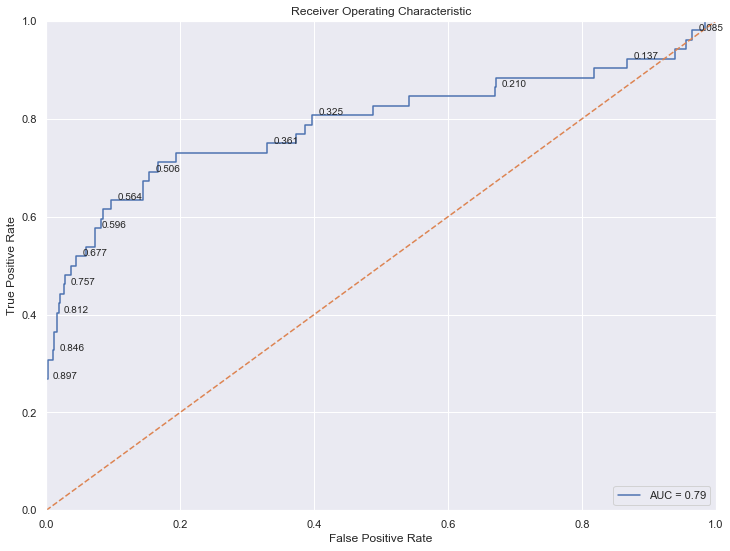

DecisionTreeClassifier


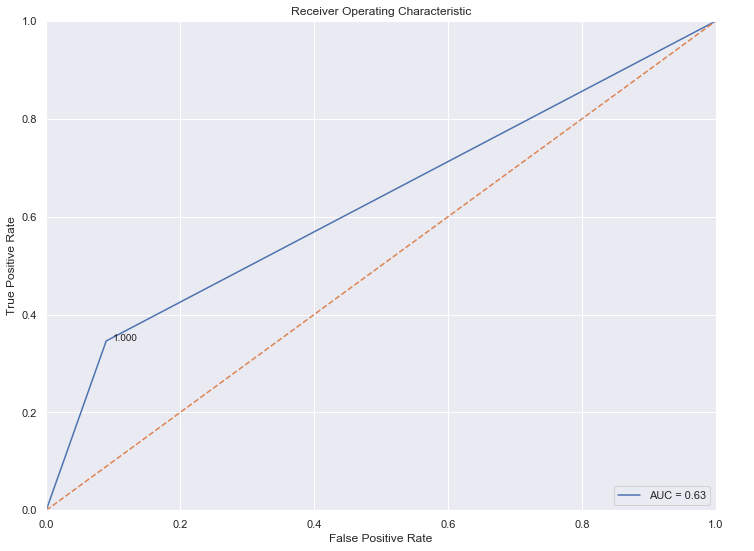

RandomForestClassifier


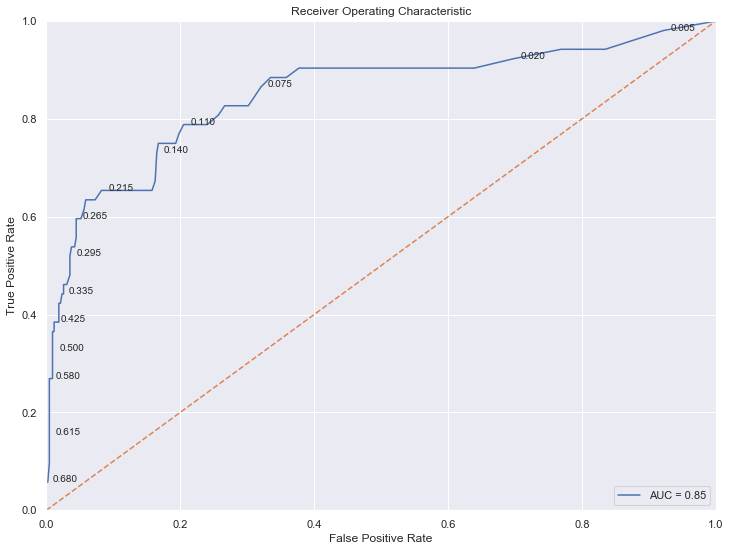

AdaBoostClassifier


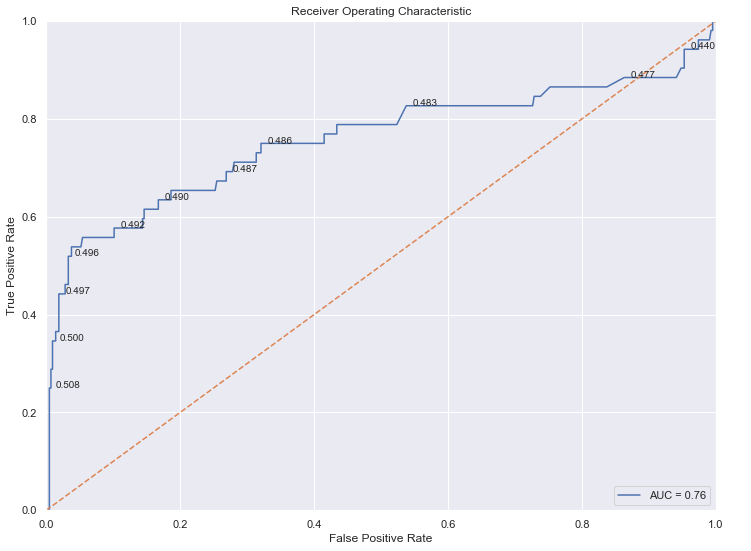

ComplementNB


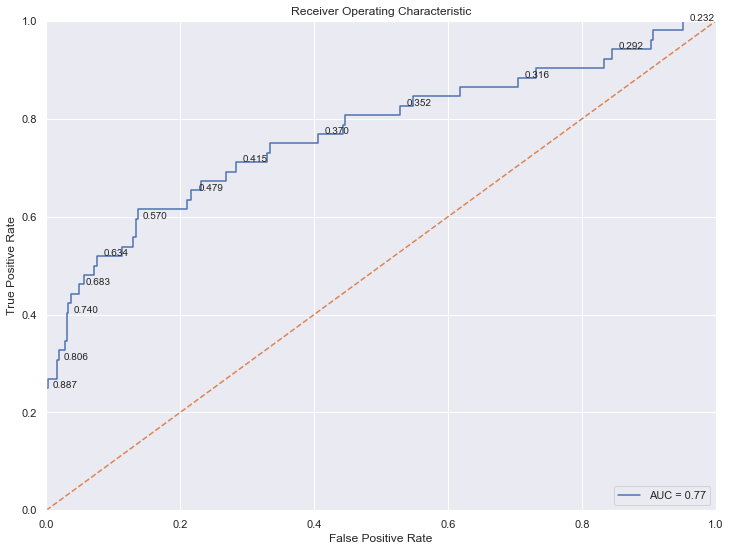

SVC


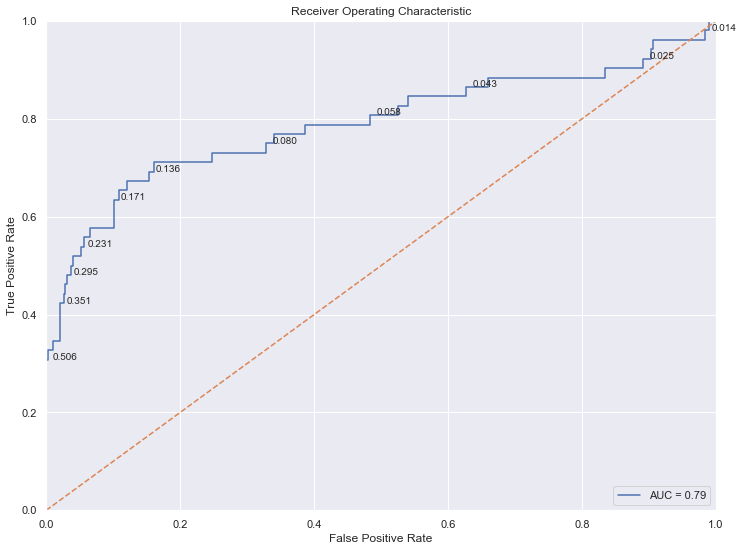

In [26]:
for cls in classifiers:
    print(type(cls).__name__)
    create_roc_auc_plot(cls.predict_proba(X_test)[:,1], y_test)

Die obigen Abbildungen zeigen die ROC Kurve für jeden der Klassifikatoren. Der draus berechnete AUC Score gibt ein weiteres Maß für die Bewertung der Klassifikatoren an. Den höchsten AUC Score erreicht der Random Forest Klassifikator mit 0,85. Aufgrund des Overfittings sagt der Entscheidungsbaum nur die Wahrscheinlichkeiten 0 oder 1 vorher und dementsprechend kann es auch nur einen Schwellwert geben. Der AUC Score ist daher sehr gering.
Wie zu erwarten haben die logistische Regression und lineare SVM den gleichen AUC Score, liegen aber deutlich unter dem Random Forest.